In [ ]:
! git clone "https://github.com/qqwweee/keras-yolo3.git"

Cloning into 'keras-yolo3'...
remote: Enumerating objects: 144, done.
remote: Total 144 (delta 0), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (144/144), 151.08 KiB | 8.89 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2022-05-19 06:51:29--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  82.3MB/s    in 2.9s    

2022-05-19 06:51:32 (82.3 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [ ]:
!nvidia-smi

Thu May 19 06:47:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
#========여기부터 실행=====================
!pip install h5py==2.10.0 --force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 9.6 MB/s 
     |████████████████████████████████| 15.7 MB 56.3 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
google-colab 1.0.0 requires six~=1.15.0, but you have si

In [6]:
#기존 케라스 삭제
!pip uninstall q keras

Found existing installation: q 2.6
Uninstalling q-2.6:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/q-2.6.dist-info/*
    /usr/local/lib/python3.7/dist-packages/q.py
Proceed (y/n)? y
  Successfully uninstalled q-2.6
Found existing installation: Keras 2.3.1
Uninstalling Keras-2.3.1:
  Would remove:
    /tensorflow-1.15.2/python3.7/Keras-2.3.1.dist-info/*
    /tensorflow-1.15.2/python3.7/docs/*
    /tensorflow-1.15.2/python3.7/keras/*
Proceed (y/n)? y
  Successfully uninstalled Keras-2.3.1


In [7]:

#케라스 2.2설치
!pip install q keras==2.1.5
#실행 후 런타임 다시 시작필수!

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached q-2.6-py2.py3-none-any.whl (6.8 kB)


In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
import os
os.chdir('/content/gdrive/MyDrive/keras-yolo3')

In [ ]:
!python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5

Using TensorFlow backend.
Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
2022-05-20 09:59:53.124219: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-05-20 09:59:53.211125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-20 09:59:53.212109: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Found device 0 with properties: 
name: Tesla P100-PCIE-16GB major: 6 minor: 0 memoryClockRate(GHz): 1.3285
pciBusID: 0000:00:04.0
2022-05-20 09:59:53.238332: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudar

In [4]:
from pathlib import Path

HOME_DIR = str(Path.home())

In [5]:
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data 

import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from train import get_classes, get_anchors
from train import create_model,create_tiny_model, data_generator, data_generator_wrapper

BASE_DIR = os.path.join(HOME_DIR, '/content/gdrive/MyDrive/keras-yolo3')
ANNO_DIR = os.path.join(HOME_DIR, '/content/gdrive/MyDrive/keras-yolo3')
IMAGE_DIR = os.path.join(HOME_DIR, '/content/gdrive/Shareddrives/deep_learning_team_project/data/training/image')

annotation_path = os.path.join(ANNO_DIR, 'total_label.txt')
log_dir = os.path.join(BASE_DIR, 'snapshots/000/')
if not os.path.exists(log_dir):
  os.makedirs(log_dir)

classes_path = os.path.join(BASE_DIR, 'model_data/train_class.txt') 
anchors_path = os.path.join(BASE_DIR,'model_data/yolo_anchors.txt')

class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

model_weights_path = '/content/gdrive/MyDrive/keras-yolo3/model_data/yolo.h5'

input_shape = (416,416) # yolo-3 416 을 사용하므로 이렇게 정의.

model = create_model(input_shape, anchors, num_classes,
                      freeze_body=2, weights_path=model_weights_path) # make sure you know what you freeze

# epoch 마다 call back 하여 모델 파일 저장.
logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=False, save_best_only=False, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

Using TensorFlow backend.







Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.7/dist-packages/keras/engine/topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.7/dist-packages/keras/engine/topology.py:3462: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in 

Load weights /content/gdrive/MyDrive/keras-yolo3/model_data/yolo.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
val_split = 0.2  # train data : val_data = 9 : 1

with open(annotation_path) as f:
    lines = f.readlines()

# 랜덤 시드 생성 및 lines 셔플하기
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)

# 데이터셋 나누기
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

In [ ]:
# create_model() 로 반환된 yolo모델에서 trainable=False로 되어 있는 layer들 제외하고 학습
if True:
    # optimizer와 loss 함수 정의
    # 위에서 사용한 create_model 클래스의 맴버함수를 사용한다. 
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 32
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    
    # foward -> backpropagation -> weight 갱신 -> weight 저장
    model.fit_generator(
            data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=30,
            initial_epoch = 0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

Train on 14729 samples, val on 3682 samples, with batch size 32.
Epoch 1/30
460/460 [==============================] - 1705s 4s/step - loss: 225.1567 - val_loss: 33.8497
Epoch 2/30
460/460 [==============================] - 1604s 3s/step - loss: 29.6063 - val_loss: 25.2661
Epoch 3/30
460/460 [==============================] - 1583s 3s/step - loss: 24.3639 - val_loss: 22.8233
Epoch 4/30
460/460 [==============================] - 1567s 3s/step - loss: 22.4001 - val_loss: 21.6009
Epoch 5/30
460/460 [==============================] - 1541s 3s/step - loss: 21.3965 - val_loss: 20.7642
Epoch 6/30
460/460 [==============================] - 1574s 3s/step - loss: 20.6876 - val_loss: 20.2523
Epoch 7/30
460/460 [==============================] - 1626s 4s/step - loss: 20.2431 - val_loss: 19.8301
Epoch 8/30
460/460 [==============================] - 1617s 4s/step - loss: 19.8842 - val_loss: 19.6999
Epoch 9/30
460/460 [==============================] - 1619s 4s/step - loss: 19.6343 - val_loss: 19.469

In [ ]:
import keras
model.load_weights('/content/gdrive/MyDrive/keras-yolo3/snapshots/000/trained_weights_stage_1.h5')

In [ ]:
# create_model() 로 반환된 yolo모델에서 trainable=False로 되어 있는 layer들 없이, 모두 True로 만들고 다시 학습
if True:
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(
        data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=60,
        initial_epoch=30,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')


Unfreeze all of the layers.
Train on 14729 samples, val on 3682 samples, with batch size 16.




Epoch 31/60
920/920 [==============================] - 11630s 13s/step - loss: 15.8329 - val_loss: 14.9640

Epoch 32/60
920/920 [==============================] - 1622s 2s/step - loss: 14.6197 - val_loss: 14.2349
Epoch 33/60
920/920 [==============================] - 1625s 2s/step - loss: 13.8150 - val_loss: 13.7718
Epoch 34/60
920/920 [==============================] - 1641s 2s/step - loss: 13.1426 - val_loss: 12.8555
Epoch 35/60
920/920 [==============================] - 1638s 2s/step - loss: 12.4618 - val_loss: 12.2253
Epoch 36/60
920/920 [==============================] - 1642s 2s/step - loss: 11.8477 - val_loss: 11.7777
Epoch 37/60
920/920 [==============================] - 1630s 2s/step - loss: 11.2690 - val_loss: 11.0924
Epoch 38/60
920/920 [==============================] - 1595s 2s/step - loss: 10.7797 - val_loss: 10.6301
Epoch 39/60
920/920 [==============================] - 1578

In [6]:
# YOLO 객체 생성. 
import sys
import argparse
from PIL import Image

LOCAL_PACKAGE_DIR = os.path.abspath("./keras-yolo3")
sys.path.append(LOCAL_PACKAGE_DIR)

In [7]:
from yolo import YOLO, detect_video
cloth_yolo = YOLO(
            model_path=os.path.join(HOME_DIR,'/content/gdrive/MyDrive/keras-yolo3/snapshots/000/trained_weights_final.h5'),
            anchors_path='/content/gdrive/MyDrive/keras-yolo3/model_data/yolo_anchors.txt',
            classes_path='/content/gdrive/MyDrive/keras-yolo3/model_data/train_class.txt')

/content/gdrive/MyDrive/keras-yolo3/snapshots/000/trained_weights_final.h5 model, anchors, and classes loaded.


['/content/gdrive/MyDrive/Colab Notebooks/딥러닝 term project/musinsa test image/detail_18402_1_500.jpg'
 '/content/gdrive/MyDrive/Colab Notebooks/딥러닝 term project/musinsa test image/detail_17881_1_500.jpg'
 '/content/gdrive/MyDrive/Colab Notebooks/딥러닝 term project/musinsa test image/detail_26569_1_500.jpg'
 '/content/gdrive/MyDrive/Colab Notebooks/딥러닝 term project/musinsa test image/detail_22814_2_500.jpg'
 '/content/gdrive/MyDrive/Colab Notebooks/딥러닝 term project/musinsa test image/detail_24977_2_500.jpg'
 '/content/gdrive/MyDrive/Colab Notebooks/딥러닝 term project/musinsa test image/detail_23684_1_500.jpg'
 '/content/gdrive/MyDrive/Colab Notebooks/딥러닝 term project/musinsa test image/detail_24969_1_500.jpg'
 '/content/gdrive/MyDrive/Colab Notebooks/딥러닝 term project/musinsa test image/detail_17386_1_500.jpg'
 '/content/gdrive/MyDrive/Colab Notebooks/딥러닝 term project/musinsa test image/detail_25806_2_500.jpg'
 '/content/gdrive/MyDrive/Colab Noteb

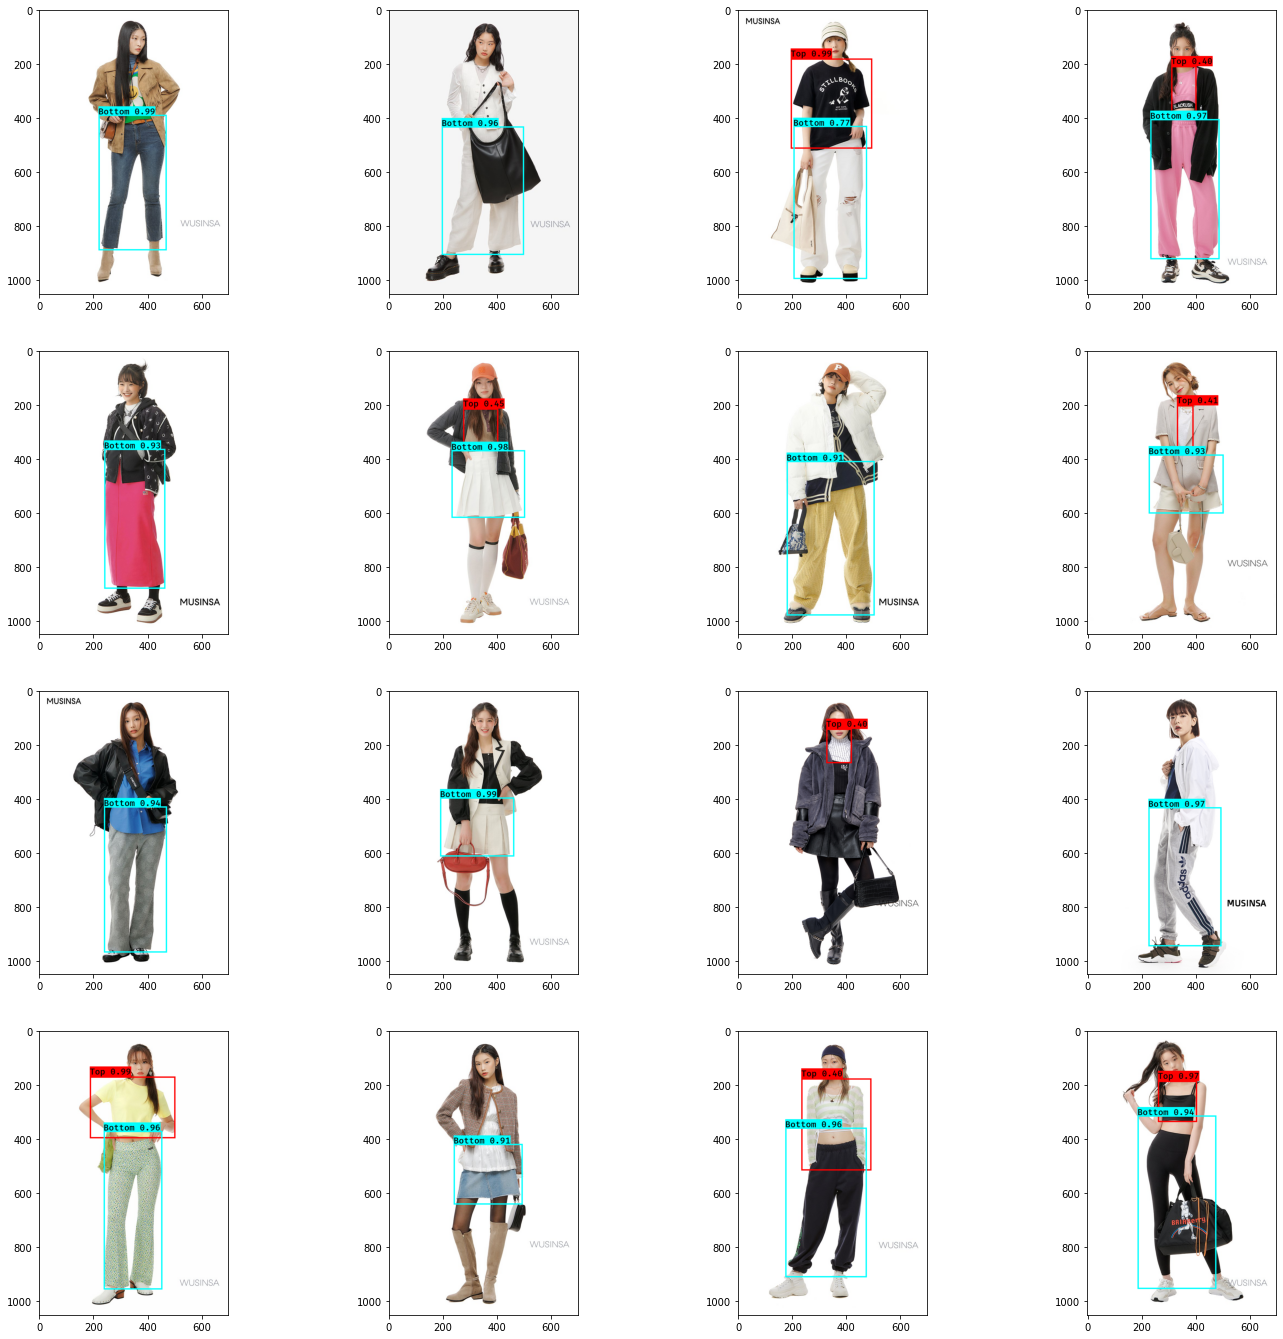

In [9]:
import numpy as np
import glob
import matplotlib.pyplot as plt
np.random.seed(8)

# 랜덤하게 16개의 이미지 파일만 선택.
# 랜덤 숫자 만을 이용하지 말고 아래와 같은 방법을 이용하면, 알아서 random하게 파일을 선택해준다. 
IMAGE_DIR = os.path.join(HOME_DIR, '/content/gdrive/MyDrive/Colab Notebooks/딥러닝 term project/musinsa test image')
all_image_files = glob.glob(IMAGE_DIR + '/*.jpg')
all_image_files = np.array(all_image_files)
file_cnt = all_image_files.shape[0]
show_cnt = 16
show_indexes = np.random.choice(file_cnt, show_cnt)
show_files = all_image_files[show_indexes]
print(show_files)

# 16개의 
fig, axs = plt.subplots(figsize=(24,24) , ncols=4 , nrows=4)
for i , filename in enumerate(show_files):
    print(filename)
    row = int(i/4)
    col = i%4
    img = Image.open(os.path.join(IMAGE_DIR, filename))
    detected_image = cloth_yolo.detect_image(img)[0]
    axs[row][col].imshow(detected_image)

In [ ]:
directory = '/content/gdrive/Shareddrives/deep_learning_team_project/data/training/image/casual' ###
file_list = os.listdir(directory)
for filename in file_list:
  img = Image.open(directory+'/'+filename)
  detected_image, truth = cloth_yolo.detect_image(img)
  f = open('/content/gdrive/MyDrive/mAP/input/detection-results/'+filename.split('/')[-1][:-4]+'.txt','w')
  for i in range(len(truth)):
    if i != 0:
      f.write('\n')
    for j in truth[i]:
      f.write(str(j)+' ')
  f.close()

(416, 416, 3)
Found 1 boxes for img
Top 0.66 (145, 37) (605, 877)
0.05836545199963439
(416, 416, 3)
Found 1 boxes for img
Top 0.93 (171, 17) (638, 1012)
0.059688732000722666
(416, 416, 3)
Found 1 boxes for img
Bottom 0.47 (293, 269) (494, 881)
0.06165534100000514
(416, 416, 3)
Found 1 boxes for img
Top 0.31 (387, 475) (476, 646)
0.06429222099905019
(416, 416, 3)
Found 2 boxes for img
Top 0.32 (143, 22) (536, 485)
Bottom 0.93 (192, 303) (461, 890)
0.06229346899999655
(416, 416, 3)
Found 2 boxes for img
Top 0.91 (452, 266) (630, 514)
Bottom 0.89 (422, 477) (633, 1002)
0.32422406499972567
(416, 416, 3)
Found 2 boxes for img
Top 0.62 (219, 282) (557, 948)
Bottom 0.30 (137, 822) (532, 1049)
0.06443106600090687
(416, 416, 3)
Found 2 boxes for img
Top 0.81 (243, 231) (509, 588)
Bottom 0.96 (242, 541) (541, 963)
0.05905201000132365
(416, 416, 3)
Found 1 boxes for img
Bottom 0.86 (200, 0) (488, 713)
0.06333891900067101
(416, 416, 3)
Found 2 boxes for img
Top 0.50 (207, 89) (464, 385)
Bottom 0.8

In [43]:
import pandas as pd

yolo_result = pd.DataFrame()
directory = os.path.join(HOME_DIR, '/content/gdrive/MyDrive/Colab Notebooks/딥러닝 term project/musinsa test image')
file_list = os.listdir(directory)
for filename in file_list:
  truth_list = []
  img_dir = str(directory+'/'+filename)
  img = Image.open(img_dir)
  detected_image, truth = cloth_yolo.detect_image(img)
  for i in truth:
    i.extend([img_dir])
    truth_list.append(i)
  print(truth_list)
  result_df = pd.DataFrame(truth, columns = ['label','left','top','right','bottom','filepath'])
  yolo_result = pd.concat([yolo_result,result_df])

yolo_result

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Top 0.60 (174, 193) (503, 482)
Bottom 0.98 (201, 344) (469, 609)
0.06102532900013102
[['Top 0.60', 174, 193, 503, 482, '/content/gdrive/MyDrive/Colab Notebooks/딥러닝 term project/musinsa test image/detail_23294_2_500.jpg'], ['Bottom 0.98', 201, 344, 469, 609, '/content/gdrive/MyDrive/Colab Notebooks/딥러닝 term project/musinsa test image/detail_23294_2_500.jpg']]
(416, 416, 3)
Found 1 boxes for img
Bottom 0.89 (179, 496) (430, 770)
0.058002542999929574
[['Bottom 0.89', 179, 496, 430, 770, '/content/gdrive/MyDrive/Colab Notebooks/딥러닝 term project/musinsa test image/detail_23290_3_500.jpg']]
(416, 416, 3)
Found 1 boxes for img
Bottom 0.93 (195, 409) (493, 687)
0.05720403699979215
[['Bottom 0.93', 195, 409, 493, 687, '/content/gdrive/MyDrive/Colab Notebooks/딥러닝 term project/musinsa test image/detail_23256_1_500.jpg']]
(416, 416, 3)
Found 1 boxes for img
Bottom 0.93 (189, 391) (446, 645)
0.06092454899999211
[['Bottom 0.93', 189, 391, 446, 

,label,left,top,right,bottom,filepath
0,Top 0.92,230,183,458,405,/content/gdrive/MyDrive/Colab Notebooks/딥러ᄂ...
1,Bottom 0.98,242,385,497,595,/content/gdrive/MyDrive/Colab Notebooks/딥러ᄂ...
0,Top 0.99,233,187,476,379,/content/gdrive/MyDrive/Colab Notebooks/딥러ᄂ...
1,Bottom 0.99,232,361,507,636,/content/gdrive/MyDrive/Colab Notebooks/딥러ᄂ...
0,Top 0.42,295,219,377,391,/content/gdrive/MyDrive/Colab Notebooks/딥러ᄂ...
...,...,...,...,...,...,...
1,Bottom 0.64,232,347,450,886,/content/gdrive/MyDrive/Colab Notebooks/딥러ᄂ...
0,Top 0.66,242,166,452,382,/content/gdrive/MyDrive/Colab Notebooks/딥러ᄂ...
1,Bottom 0.84,233,336,440,680,/content/gdrive/MyDrive/Colab Notebooks/딥러ᄂ...
0,Top 0.62,229,151,496,299,/content/gdrive/MyDrive/Colab Notebooks/딥러ᄂ...


In [45]:
yolo_result = yolo_result.reset_index()
yolo_result.to_csv('/content/gdrive/MyDrive/Colab Notebooks/딥러닝 term project/yolo_result.csv',index=False,encoding='utf-8-sig')